# Import all the Packages you will need 

In [49]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics as stat
import warnings
import os
import seaborn as sns

 
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')

# Load the Environments and get the variables form your.env file 

In [7]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [12]:
conn_str =f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Make the Connection and Read the Tables

In [13]:
# conection to the server
connection = pyodbc.connect(conn_str)

In [14]:


# import the 2020 and 2021 SQL file from the server
query1 = "Select * from LP1_startup_funding2020"
data_2020 = pd.read_sql(query1, connection)
 
query2 = "Select * from LP1_startup_funding2021"
data_2021 = pd.read_sql(query2, connection)

# Read the csv 

In [17]:
data_2018 = pd.read_csv('startup_funding2018.csv')

data_2019 = pd.read_csv('startup_funding2019.csv')

In [18]:
# to add year column to all the imported data
data_2018['Year']='2018'
data_2019['Year']='2019'
data_2020['Year']='2020'
data_2021['Year']='2021'

# Exploratory Data Analysis:EDA

cleaning and concating the two CSV files 2018 and 2019

In [ ]:
# Drop the Colunms that we may not need for the project

data_2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)

In [19]:
# Select specific columns and rename them

data_2018 = data_2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 
                                      'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
data_2019 = data_2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 
                                      'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})

Hamornizing the stage column in 2018 & 2019

Some of the data in the stage column are named differently but the still do serve the same purpose so we group them together and give them one common name foe easy analysis

In [20]:
# df2018 Dataframe 

data_2018.replace(to_replace=['Seed round', 'Seed funding', 'Early seed', 'Seed fund', 'Seed Investment', 'Seed Round', 'Seed+'], value='Seed', inplace=True)
data_2018.replace(to_replace=['Angel Round'], value='Angel', inplace=True)
data_2018.replace(to_replace=['Venture - Series Unknown'], value='Undisclosed', inplace=True)
data_2018.replace(to_replace=['Debt Financing', 'Post-IPO Debt'], value='Debt', inplace=True)
data_2018.replace(to_replace=['Private Equity', 'Post-IPO Equity'], value='Equity', inplace=True)
data_2018.replace(to_replace=['Corporate Round', 'Grant', 'Secondary Market', 'Non-equity Assistance', 'Funding Round'], value='Other', inplace=True)
data_2018.replace(to_replace=['Pre-Series B', 'Pre-series B'], value='Pre-Seed', inplace=True)

In [21]:
# df2019 Dataframe

data_2019.replace(to_replace=['Seed funding', 'Seed fund', 'Seed round'], value='Seed', inplace=True)
data_2019.replace(to_replace=['Pre series A', 'Pre-series A'], value='Pre-Seed', inplace=True)
data_2019.replace(to_replace=['Series B+'], value='Series B', inplace=True)
data_2019.replace(to_replace=['Post series A', 'Fresh funding'], value='Other', inplace=True)

<b>Harmonising the HeadQuater/Location column entries in 2018&2019 data.<b>

some of the locations  in the headquarter  has spelling error, some are the same location with different names while some are outside india so he group them and give them common name for easy analysis 

In [22]:
# code to sparete the headquarters in 2018 because the columns contain more than one headquarter which will affect the analysis

data_2018_new=data_2018['HeadQuarter'].str.split(pat=',', n=1, expand=True) 
data_2018['Head']=data_2018_new[0]

In [23]:
# drop headquarter column
data_2018.drop(['HeadQuarter'], axis=1, inplace=True)
# rename the head column
data_2018.rename(columns={'Head':'HeadQuarter'}, inplace=True)

In [24]:
# data cleaning of headquarter in 2018
data_2018.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2018.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2018.replace(to_replace=['Cochin'], value='Kochi', inplace=True)
data_2018.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2018.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2018.replace(to_replace=['Uttar Pradesh', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
data_2018.replace(to_replace=['Trivandrum', 'India'], value='Trivandrum', inplace=True)


# data cleaning of headquarter in 2019
data_2019.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)

<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df2018 & df2019<b>

In [25]:
# check for duplicates
data_2018.duplicated().value_counts()

False    525
True       1
Name: count, dtype: int64

In [26]:
# drop the duplicates
data_2018.drop_duplicates(keep='first', inplace=True)

In [27]:
data_2019.duplicated().value_counts()

False    89
Name: count, dtype: int64

Merging 2018 & 2019 and Checking for currency

In the currency colunn in 2018 and 2019 some amount are in  Dollar, some are in Rupee while sum are just numeric so we converted all of them to Dollar for easy analysis

In [28]:
# Merge the two csv files 

data_18_19 = pd.concat([data_2018, data_2019], ignore_index=True)

In [29]:
# # # Assuming exchange rate is: 4 INR = 0.012 USD)
 

# # Create a new column 'currency' based on currency symbols

data_18_19['currency'] = data_18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))

# # # Create columns 'amount_inr' and 'amount_usd'

data_18_19['amount_inr'] = data_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
data_18_19['amount_usd'] = data_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

# # # Remove the currency sysmbols and the commas 

data_18_19['amount_inr'] = data_18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
data_18_19['amount_usd'] = data_18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

# # # Replace 'Undisclosed' values with NaN

data_18_19['amount_inr'] = data_18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
data_18_19['amount_usd'] = data_18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

# # # Convert the object values into numeric values for calculation

data_18_19['amount_inr'] = pd.to_numeric(data_18_19['amount_inr'], errors='coerce')
data_18_19['amount_usd'] = pd.to_numeric(data_18_19['amount_usd'], errors='coerce')





# # Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'
data_18_19['Updated_Amount'] = data_18_19['amount_inr'].fillna(data_18_19['amount_usd'])

In [30]:
data_18_19.drop(['currency', 'amount_inr','amount_usd','Amount'], axis=1, inplace=True)

In [31]:
# # Rename the updated_ amount column to amount 
data_18_19.rename(columns={'Updated_Amount':'Amount($)'}, inplace=True )

Cleaning and concating the two SQL file 2020 & 2021

In [32]:
# Renaming the Column to have the same column names for all the tables

data_2020 = data_2020.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 
                                      'Amount': 'Amount', 'What_it_does': 'BIO', 'Location':'HeadQuarter'})
data_2021 = data_2021.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 
                                      'Amount': 'Amount', 'What_it_does': 'BIO', 'HeadQuarter':'HeadQuarter'})

<b> Drop some columns that might not be needed for the analysis like founded, founders, investors and column10 which is not also included in 2018 file <b>

In [33]:
# we drop some columns we will not use for the analysis and does not ryme with the 2018 data
data_2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data_2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data_2020.drop(columns=['column10'], inplace=True)

<b>Harmonising the HeadQuarter column entries in 2020&2021 data.<b>

In [34]:

#  cleaning of HeadQuater 2020
data_2020.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2020.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2020.replace(to_replace=['Ahmadabad'], value='Ahmedabad', inplace=True)
data_2020.replace(to_replace=['Kochi'], value='Cochin', inplace=True)
data_2020.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2020.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2020.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2020.replace(to_replace=['Small Towns', 'Andhra Pradesh','Uttar Pradesh'], value='Andhra Pradesh', inplace=True)
data_2020.replace(to_replace=['Hyderebad'], value='Hyderabad', inplace=True)
data_2020.replace(to_replace=['Gurugram\t#REF!'], value='Gurugram', inplace=True)
data_2020.replace(to_replace=['Orissia'], value='Orissa', inplace=True)
data_2020.replace(to_replace=['Samstipur','Samastipur, Bihar','Samsitpur'], value='Samastipur', inplace=True)
data_2020.replace(to_replace=['The Nilgiris'], value='Nilgiris', inplace=True)
data_2020.replace(to_replace=['Dhindsara', 'Haryana','Dhingsara, Haryana'], value='Dhingsara', inplace=True)
data_2020.replace(to_replace=['Tirunelveli', 'Tamilnadu'], value='Tirunelveli', inplace=True)
data_2020.replace(to_replace=['Mylapore'], value='Chennai', inplace=True)
data_2020.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2020.replace(to_replace=['Trivandrum', 'Kerala, India'], value='Trivandrum', inplace=True)


#  Renaming some of the headquarters the are not in India to outside india in data 2020
data_2020.replace(to_replace=['Frisco', 'France','Newcastle Upon Tyne, Newcastle upon Tyne, United Kingdom',
                              'Frisco, Texas, United States','Irvine, California, United States',
                              'San Francisco Bay Area, West Coast, Western US','Texas, United States','California',
                              'New York, United States','San Francisco, California, United States','San Francisco, United States',
                              'San Ramon, California','Paris, Ile-de-France, France','Plano, Texas, United States','Sydney',
                              'San Francisco Bay Area, Silicon Valley, West Coast','Bangaldesh','London, England, United Kingdom','Sydney, New South Wales, Australia',
                              'Milano, Lombardia, Italy','Palmwoods, Queensland, Australia', 'France''Irvine, California, United States',
                              'Newcastle Upon Tyne, Newcastle upon Tyne United Kingdom','Shanghai, China','Jiaxing, Zhejiang, China',
                              'San Franciscao','San Francisco','New York'], value = 'Outside India', inplace=True)


# filling of missing headquarters in 2020
data_2020['HeadQuarter'].fillna('Undisclosed', inplace=True)

In [35]:
#  cleaning of HeadQuater 2021
data_2021.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2021.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2021.replace(to_replace=['Ahmadabad'], value='Ahmedabad', inplace=True)
data_2021.replace(to_replace=['Kochi'], value='Cochin', inplace=True)
data_2021.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2021.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2021.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2021.replace(to_replace=['Small Towns', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
data_2021.replace(to_replace=['Hyderebad'], value='Hyderabad', inplace=True)
data_2021.replace(to_replace=['Gurugram\t#REF!'], value='Gurugram', inplace=True)
data_2021.replace(to_replace=['The Nilgiris'], value='Nilgiris', inplace=True)
data_2021.replace(to_replace=['Dhindsara', 'Haryana','Dhingsara, Haryana'], value='Dhingsara', inplace=True)
data_2021.replace(to_replace=['Tirunelveli, Tamilnadu'], value='Tirunelveli', inplace=True)
data_2021.replace(to_replace=['Mylapore'], value='Chennai', inplace=True)
data_2021.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2021.replace(to_replace=['Trivandrum', 'Kerala', 'India'], value='Trivandrum', inplace=True)
data_2021.replace(to_replace=['unknown'], value='Undisclosed', inplace=True)



#  Renaming some of the headquarters the are not in India to outside india in data 2020
data_2021.replace(to_replace=['London', 'New York', ' Mountain View', 'CA ', 'Beijing', '' ], value='Outside_India', inplace=True)
data_2021.replace(to_replace=['Online Media\t#REF!', 'Pharmaceuticals\t#REF!', 'Food & Beverages', 
                             'Computer Games', 'Small Towns', ' None', 'None', 'Information Technology & Services'], value='Undisclosed', inplace=True)
data_2021.replace(to_replace=['Gurugram\t#REF!' ], value='Gurugrama', inplace=True)

data_2021['HeadQuarter'].fillna('Undisclosed', inplace=True)

<b> Currency Conversion<b>

In [36]:
# Merge the two sql files 

df20_21 = pd.concat([data_2020, data_2021], ignore_index=True)

In [37]:
# # Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df20_21['Updated_Amount'] = df20_21['Amount']

In [38]:
# # Create a column 'with_$' for values with '$' sign and 'without_$' for values without '$'

df20_21['with_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' in str(x) else None)
df20_21['without_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' not in str(x) else None)

# # Remove the currency sysmbols and the commas 

df20_21['with_$'] = df20_21['with_$'].str.replace('$', '')
# # Replace 'Undisclosed' values with NaN

df20_21['with_$'] = df20_21['with_$'].replace('Undisclosed', np.nan, regex=True)
# # Convert the object values into numeric values for calculation

df20_21['with_$'] = pd.to_numeric(df20_21['with_$'], errors='coerce')
df20_21['without_$'] = pd.to_numeric(df20_21['without_$'], errors='coerce')

In [39]:
# # Merge the two Colunms into a new colunm 'without_$' and with_$ together

df20_21['Updated_Amount'] = df20_21['without_$'].fillna(df20_21['with_$'])

In [40]:
# # drop some new columns created and rename the updated _amount column
df20_21.drop(['Amount','with_$','without_$'], axis=1, inplace=True)
df20_21.rename(columns={'Updated_Amount':'Amount($)'}, inplace=True)

In [41]:
# cheking for duplicates in the csv files 2020 qmd 2021
df20_21.duplicated().value_counts()

# drop duplicates
df20_21.drop_duplicates(keep='first',inplace=True)

# Merging All the Files Together

In [42]:
# merging  all the tabgles together
india_startup_df = pd.concat([data_18_19, df20_21], ignore_index=True)

In [43]:
# Filling the missing value in stage column 
india_startup_df['Sector'].fillna('Unknown', inplace=True)

In [44]:
# merging some of the sector data together base on the services they lender 
india_startup_df.loc[india_startup_df['Sector'].str.contains('Finance'),'Sector']= 'Financial Institution'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Education'),'Sector']= 'Education'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Health'), 'Sector'] = 'Health Care'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Marketing'), 'Sector'] = 'Marketing Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Commerce'), 'Sector']= 'E-Commerce'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Artificial'),'Sector']= 'Artificial intelligence'
india_startup_df.loc[india_startup_df['Sector'].str.contains('AI'),'Sector']= 'Artificial intelligence'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Farming'),'Sector']= 'Agriculture'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Agriculture'),'Sector']= 'Agriculture'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Internet'),'Sector']= 'Internet Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Computer'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Financial'),'Sector']= 'Financial Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Tech'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Transportation'),'Sector']= 'Transport Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Software'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Home'),'Sector']= 'Home'
india_startup_df.loc[india_startup_df['Sector'].str.contains('SaaS'),'Sector']= 'Internet Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('PaaS'),'Sector']= 'Internest Services'

<b> Harmonising and cleaning the stage column<b>

In [45]:
# filling the missing values in stage column
india_startup_df['Stage'].fillna('Undisclosed', inplace=True)

In [ ]:
# grouping some of the stages together to have one commomn name
india_startup_df.loc[india_startup_df['Stage'].str.contains('Series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Post series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Pre-series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('seed'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Undisclose'), 'Stage'] = 'Undisclosed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Funding'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('funding'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Seed'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Grant'), 'Stage'] = 'Debt'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Debt'), 'Stage'] = 'Dept'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Seies'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('0'), 'Stage'] = 'Angel'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Equity'), 'Stage'] = 'Equity'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Edge'), 'Stage'] = 'Bridge'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Bridge'), 'Stage'] = 'Bridge'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Angel'), 'Stage'] = 'Angel'

In [46]:
india_startup_df[india_startup_df['Stage'].str.startswith('https') == False]

,Company_Brand,Sector,Stage,BIO,Year,HeadQuarter,Founded,Founders,Investor,Amount($)
0,TheCollegeFever,Marketing Services,Seed,"TheCollegeFever is a hub for fun, fiesta and f...",2018,Bangalore,NaN,NaN,NaN,250000.0
1,Happy Cow Dairy,Agriculture,Seed,A startup which aggregates milk from dairy far...,2018,Mumbai,NaN,NaN,NaN,40000000.0
2,MyLoanCare,Financial Services,Series A,Leading Online Loans Marketplace in India,2018,Gurgaon,NaN,NaN,NaN,65000000.0
3,PayMe India,Financial Services,Angel,PayMe India is an innovative FinTech organizat...,2018,Noida,NaN,NaN,NaN,2000000.0
4,Eunimart,E-Commerce,Seed,Eunimart is a one stop solution for merchants ...,2018,Hyderabad,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2842,Gigforce,Staffing & Recruiting,Pre-series A,A gig/on-demand staffing company.,2021,Gurugram,NaN,NaN,NaN,3000000.0
2843,Vahdam,Undisclosed,Series D,VAHDAM is among the world’s first vertically i...,2021,Delhi,NaN,NaN,NaN,20000000.0
2844,Leap Finance,Financial Services,Series C,International education loans for high potenti...,2021,Bangalore,NaN,NaN,NaN,55000000.0
2845,CollegeDekho,Technology,Series B,"Collegedekho.com is Student’s Partner, Friend ...",2021,Gurugram,NaN,NaN,NaN,26000000.0


# ANALYSIS - ANWERING ANALYTICAL QUESTIONS ON THE DATA


QUESTION 1
 which Headquarter has the most populated start up location

In [47]:
most_pop_location = india_startup_df.groupby('HeadQuarter')['Sector'].count().reset_index()
most_pop_location = most_pop_location.sort_values(by='Sector', ascending = False)
most_pop_location.head(5)

,HeadQuarter,Sector
8,Bangalore,862
61,Mumbai,469
23,Delhi,315
35,Gurugram,239
19,Chennai,105


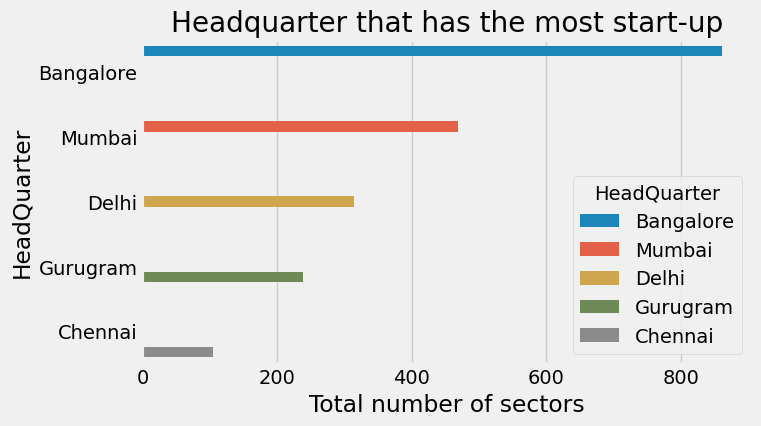

In [50]:
plt.figure(figsize=(7, 4))
plt.title('Headquarter that has the most start-up')
plt.style.use('fivethirtyeight')
sns.barplot(y='HeadQuarter', x='Sector', palette=None, data=most_pop_location.iloc[:5], orient='h', hue='HeadQuarter')

plt.ylabel('HeadQuarter')
plt.xlabel('Total number of sectors')
plt.show()

Question 2
<b> top 10 headquarter that has the highest start up funding<b>

In [51]:
top_10_startup_amount = india_startup_df.groupby('HeadQuarter')['Amount($)'].sum().reset_index()
top_10_startup_amount = top_10_startup_amount.sort_values(by='Amount($)', ascending=False)
top_10_startup_amount.head(10)

,HeadQuarter,Amount($)
61,Mumbai,9.950212e+10
8,Bangalore,2.247874e+10
37,Haryana,2.073980e+10
23,Delhi,1.910667e+10
12,Bengaluru,8.732550e+09
34,Gurgaon,6.653433e+09
41,Jaipur,6.006575e+09
35,Gurugram,4.833832e+09
68,Outside India,4.221500e+09
73,Pune,2.109737e+09


<function matplotlib.pyplot.show(close=None, block=None)>

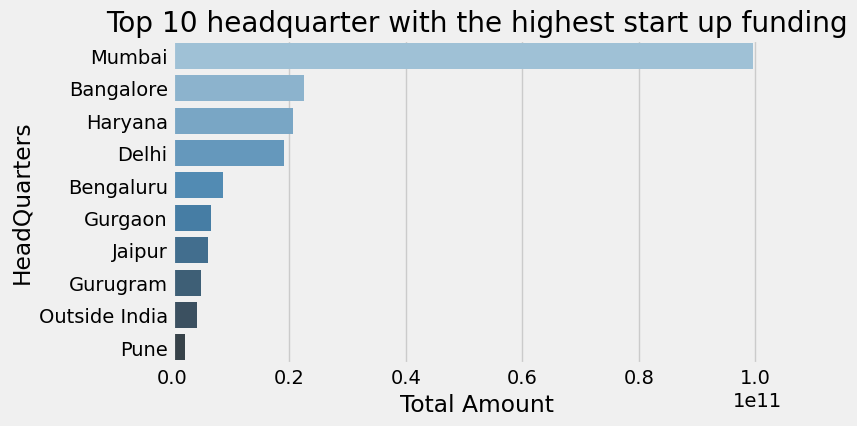

In [52]:
plt.figure(figsize=(7,4))
plt.title('Top 10 headquarter with the highest start up funding')
plt.style.use('fivethirtyeight')
sns.barplot(x='Amount($)',y='HeadQuarter', palette='Blues_d', data=top_10_startup_amount.iloc[:10])

plt.ylabel('HeadQuarters')
plt.xlabel('Total Amount')

plt.show

In [ ]:
Question 3 <b>top 10 sector that recieve the highest start up funding<b>

In [55]:
top_10_sector_amount = india_startup_df.groupby('Sector')['Amount($)'].sum().reset_index()
top_10_sector_amount = top_10_sector_amount.sort_values(by='Amount($)', ascending=False)
top_10_sector_amount.head(10)

,Sector,Amount($)
441,Retail,7.047448e+10
243,Financial Services,3.372333e+10
12,Aerospace,2.000000e+10
481,Technology,1.833937e+10
329,Internet Services,5.087982e+09
190,E-Commerce,3.396960e+09
296,Health Care,2.734647e+09
497,Transport Services,2.428250e+09
299,Home,2.272200e+09
388,Multinational conglomerate company,2.200000e+09


<function matplotlib.pyplot.show(close=None, block=None)>

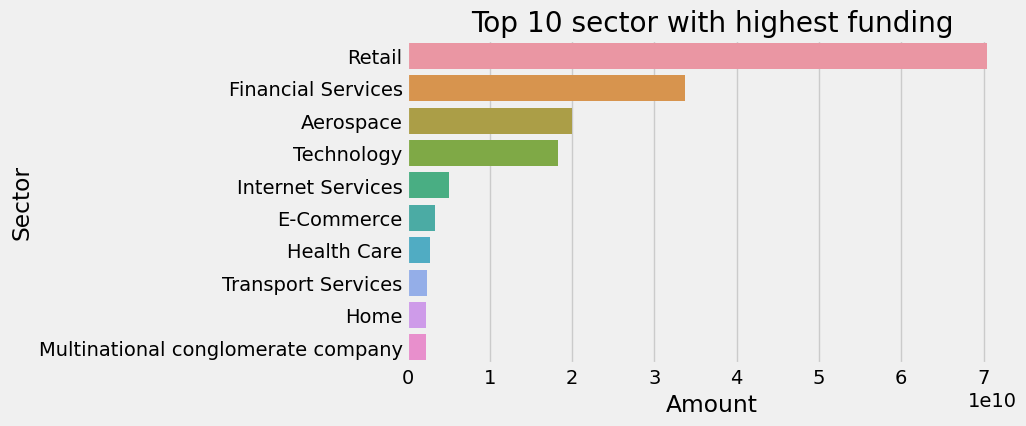

In [56]:
plt.figure(figsize=(7,4))
plt.title('Top 10 sector with highest funding')
plt.style.use('fivethirtyeight')

sns.barplot(y='Sector', x='Amount($)', palette=None, data=top_10_sector_amount.iloc[:10])

plt.ylabel('Sector')
plt.xlabel('Amount')  

plt.show

Question 4
<b>Which year recieved has the most start up funding<b>

In [57]:
india_startup_df['Amount($)'].sum()

203393139295.0

In [58]:
year_startup_funding=india_startup_df.groupby('Year')['Amount($)'].mean().reset_index()
year_startup_funding=year_startup_funding.sort_values(by='Amount($)', ascending=False)
year_startup_funding

,Year,Amount($)
0,2018,2.398020e+08
2,2020,1.127288e+08
1,2019,4.333030e+07
3,2021,2.841682e+07


<function matplotlib.pyplot.show(close=None, block=None)>

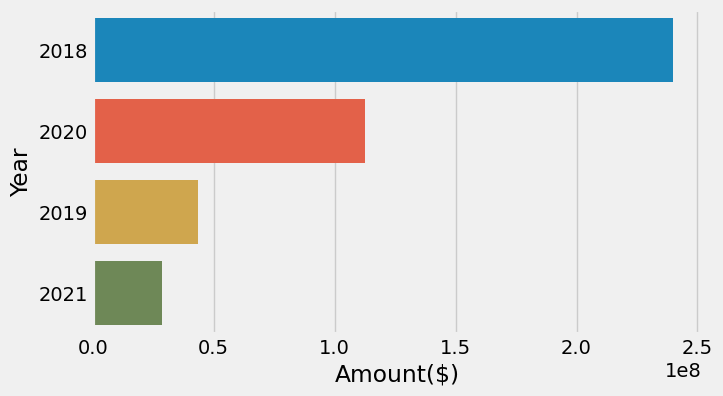

In [59]:
plt.figure(figsize=(7,4))

sns.barplot(y='Year',x='Amount($)',palette=None, data=year_startup_funding)

plt.show

Question 5 <b>What is the funding trend in the Indian start-up ecosystem over the past few years<b>

In [60]:
# Get the Sum

total_funding = india_startup_df.groupby('Year')['Amount($)'].mean()

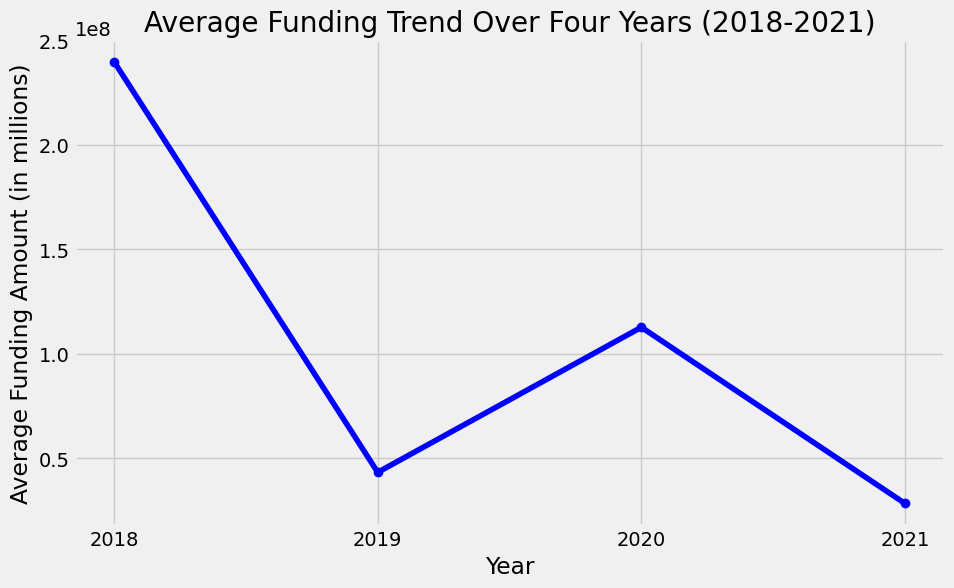

In [61]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding.index, total_funding.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Funding Amount (in millions)')
plt.title('Average Funding Trend Over Four Years (2018-2021)')
plt.grid(True)
plt.show()

# HYPOTHESIS

Ho: Location of a sector dose not have an impact on the amount of funding

H1: Locattion of a sector has an impact on the amount of funding

From the analysis we find out that location has no effect on the amount of start of funding because Bangalore has the highest sector location but Mumbai has the highest start-up funding

In [62]:
import pandas as pd
from io import StringIO

# Assuming india_startup_df is your DataFrame

# Convert the DataFrame to a CSV-formatted string
csv_data = india_startup_df.to_csv(index=False)

# Read the CSV-formatted string using StringIO
df = pd.read_csv(StringIO(csv_data))

# Specify the file path where you want to save the CSV file
csv_file_path = "indian_start_up.csv"

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print(f"CSV file '{csv_file_path}' has been created.")

CSV file 'indian_start_up.csv' has been created.
